In [1]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# To generate HOG features and images.
# Skip this cell if already generated.

label = np.load('Labels.npy')
traindat = np.load('Data.npy')
print(label.shape)
print(traindat.shape)

l = traindat.shape[0]
trainimages = np.empty(l, dtype=object)
trainimages_hog = np.empty(l, dtype=object)
features_hog = np.empty(l, dtype=object)
hog_images = []
hog_features = []

print(l)
for n in range(0, l):
    
    #print(trainimages[n].shape)
    trainimages[n] = cv2.resize(traindat[n,:,:,:], (128,64)) 
    #print(trainimages[n].shape)
    #print(n)
    
        
    features_hog[n], trainimages_hog[n] = hog(trainimages[n], orientations=8, pixels_per_cell=(16,16),cells_per_block=(4, 4),block_norm= 'L2',visualize=True) #hog(trainimages[n] , orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_images.append(trainimages_hog[n])
    hog_features.append(features_hog[n])

np.save("hogfeatures.npy", hog_features)
np.save("hogimages.npy", hog_images)

In [2]:
# Load the saved features and images if generated.

label = np.load('Labels.npy')
hog_features = np.load("hogfeatures.npy")
hog_images = np.load("hogimages.npy")

(7023, 64, 128)
(7023, 640)


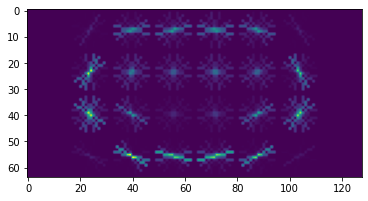

In [3]:
hog_features = np.array(hog_features)
hog_images = np.array(hog_images)
plt.imshow(hog_images[15])
plt.imsave("hog_image.jpg", hog_images[15])
print(hog_images.shape)
print(hog_features.shape)

In [3]:
# Making the train test split
train_x,test_x,train_y, test_y = train_test_split(hog_features, label, test_size= 0.2)

## Random Forrest

In [7]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(train_x, train_y.flatten())

ytr_pred=clf.predict(train_x)
start = time.time()
ytest_pred=clf.predict(test_x)
end = time.time()
print("Random forest time =", end - start)
print("Train Accuracy:",metrics.accuracy_score(train_y, ytr_pred) *100)
print("Test Accuracy:",metrics.accuracy_score(test_y, ytest_pred) *100)
print(classification_report(test_y, ytest_pred))


Random forest time = 0.04285287857055664
Train Accuracy: 100.0
Test Accuracy: 91.0320284697509
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       420
         1.0       0.93      0.83      0.88       335
         2.0       0.83      0.86      0.84       304
         3.0       0.90      0.97      0.93       346

    accuracy                           0.91      1405
   macro avg       0.91      0.91      0.90      1405
weighted avg       0.91      0.91      0.91      1405



## SVM


 Train Accuracy:  99.83980064079743

 Test Accuracy:  94.44839857651246


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       420
         1.0       0.94      0.91      0.92       335
         2.0       0.88      0.90      0.89       304
         3.0       0.98      0.98      0.98       346

    accuracy                           0.94      1405
   macro avg       0.94      0.94      0.94      1405
weighted avg       0.94      0.94      0.94      1405

[[409   3   5   3]
 [  1 304  29   1]
 [  9  17 274   4]
 [  1   0   5 340]]


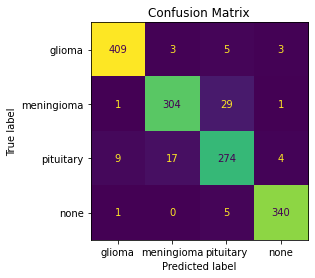

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf1 = make_pipeline(StandardScaler(), svm.SVC(C=5,gamma='auto', max_iter=-1))
clf1.fit(train_x,train_y.flatten())
y_pred = clf1.predict(test_x)
y_tr = clf1.predict(train_x)

print("\n Train Accuracy: ", (accuracy_score(train_y, y_tr))*100)
print("\n Test Accuracy: ", (accuracy_score(test_y, y_pred))*100)
print('\n')
print(classification_report(test_y, y_pred))
print(confusion_matrix(test_y, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(test_y, y_pred), display_labels=['glioma', 'meningioma', 'pituitary', 'none'])
disp.plot(colorbar=False)
plt.title("Confusion Matrix")
plt.show()

## Neural Network

In [21]:
train_x.shape

(5618, 640)

In [7]:
import tensorflow.keras.layers as tfl
def neural_network_v2(input_shape):
    
    # define the model

    initializer = tf.keras.initializers.HeNormal()
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(inputs)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)    
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(1028, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.6)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.Dropout(0.4)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

nn = neural_network_v2(train_x.shape[1])
nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'], loss=tf.keras.losses.sparse_categorical_crossentropy)

epochs = 100
batch_size = 32

history = nn.fit(train_x, train_y, epochs=epochs, batch_size = batch_size, verbose = 1, validation_data=(test_x, test_y))

Epoch 1/100
176/176 [==============================] - 4s 17ms/step - loss: 1.7047 - accuracy: 0.2811 - val_loss: 1.3913 - val_accuracy: 0.2961
Epoch 2/100
176/176 [==============================] - 3s 15ms/step - loss: 1.4535 - accuracy: 0.3355 - val_loss: 1.2726 - val_accuracy: 0.3922
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 1.2745 - accuracy: 0.4083 - val_loss: 0.9441 - val_accuracy: 0.6221
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 1.0762 - accuracy: 0.5187 - val_loss: 0.7543 - val_accuracy: 0.6918
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.9431 - accuracy: 0.5975 - val_loss: 0.7083 - val_accuracy: 0.7004
Epoch 6/100
176/176 [==============================] - 3s 17ms/step - loss: 0.8644 - accuracy: 0.6314 - val_loss: 0.6588 - val_accuracy: 0.7096
Epoch 7/100
176/176 [==============================] - 3s 15ms/step - loss: 0.8091 - accuracy: 0.6556 - val_loss: 0.6137 - val_accuracy:

In [8]:
acc = nn.evaluate(test_x, test_y, verbose = 1)
print(f"Best accuracy achieved = {acc[1]*100}")
print(classification_report(test_y, np.argmax(nn.predict(test_x, batch_size = 1), axis = 1)))

44/44 [==============================] - 0s 6ms/step - loss: 0.2830 - accuracy: 0.9117
Best accuracy achieved = 91.17437601089478
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       398
         1.0       0.93      0.80      0.86       318
         2.0       0.79      0.87      0.82       309
         3.0       0.95      0.96      0.96       380

    accuracy                           0.91      1405
   macro avg       0.91      0.90      0.90      1405
weighted avg       0.91      0.91      0.91      1405



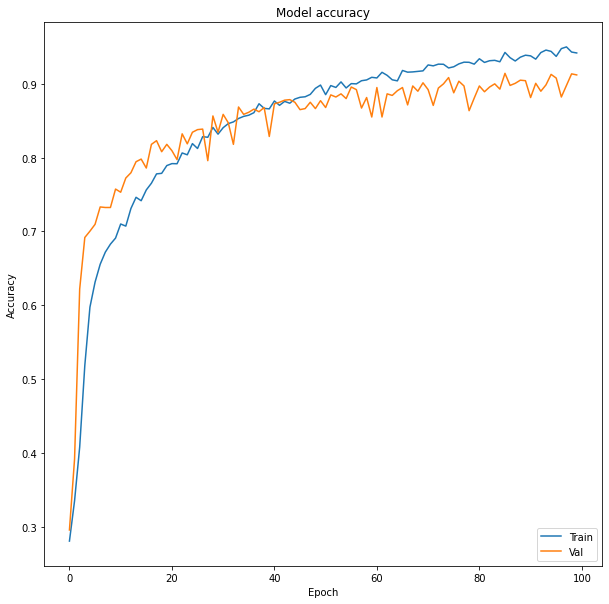

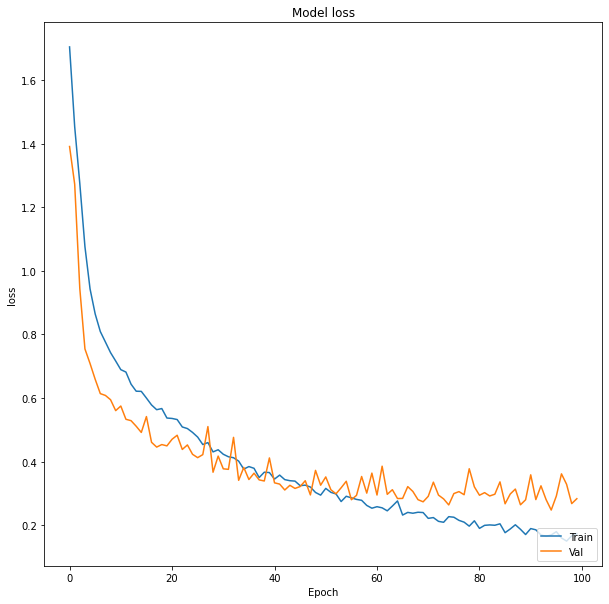

In [9]:
plt.figure(figsize =(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.figure(figsize =(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.show()

